In [1]:
import cv2
import numpy as np
import os 
import time
import pickle

from IPython.display import clear_output
from PIL import Image, ImageDraw

# My custom library of photoelastic tools
import sys
#sys.path.append('/eno/jdfeathe/pepe/')
sys.path.append('/home/jack/workspaces/jupyter-workspace/pepe/')
from pepe.preprocess import crossMask, checkImageType, circularMask, lightCorrectionDiff, rectMask, mergeMasks

from pepe.analysis import initialForceSolve, forceOptimize
from pepe.tracking import houghCircle, convCircle
from pepe.simulate import genSyntheticResponse
from pepe.utils import preserveOrderArgsort, rectangularizeForceArrays
from pepe.visualize import visContacts, visCircles, visForces, genColors
from pepe.auto import forceSolve

import progressbar

import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 140

In [2]:
#rootFolder = '/eno/jdfeathe/DATA/SpaceJam/'
rootFolder = '/run/media/jack/Seagate Portable Drive/Research/SpaceJam/'
dataFolder = '2022-03-29_Medium/'
dateStr = dataFolder.split('_')[0]

# Our radius that we will be identifying particles with
guessRadius = 160 # [px]

cropXBounds = [200, 1200]

# A particle is about 1cm across
pxPerMeter = 2*guessRadius / .015
# No idea what the actual value for this is
fSigma = 140

# How much to blur the photoelastic channel by
blurKernel = 2

# Parameters of our force solving method
contactPadding = 20
g2MaskPadding = 2
contactMaskRadius = 40
brightfield = False

maskImage = f'../masks/{dateStr}_FullMask.bmp'
verticalMaskImage = f'../masks/{dateStr}_VerticalMask.bmp'
horizontalMaskImage = f'../masks/{dateStr}_HorizontalMask.bmp'

#correctionImage = rootFolder + f'calibration/{dateStr}_Calibration.bmp'
#g2CalibrationImage = rootFolder + f'calibration/{dateStr}_G2_Calibration.bmp'
correctionImage = None
g2CalibrationImage = None

optimizationKwargs = {"maxEvals": [5, 5, 5], "method": 'nelder',
                     "parametersToFit": [['f'], ['f', 'a'], ['a']],
                     "allowRemoveForces": False, "useTolerance": False,
                     "allowAddForces": True, "minForceThreshold": .03,
                     "localizeAlphaOptimization": False}

circleTrackingKwargs = {"intensitySoftmax": 2., "intensitySoftmin": 1.8, "peakDownsample": 2,
                        "minPeakPrevalence": .1, "offscreenParticles": False,
                        "radiusTolerance": None, "negativeHalo": True, "fitPeaks": False,
                        "allowOverlap": True}

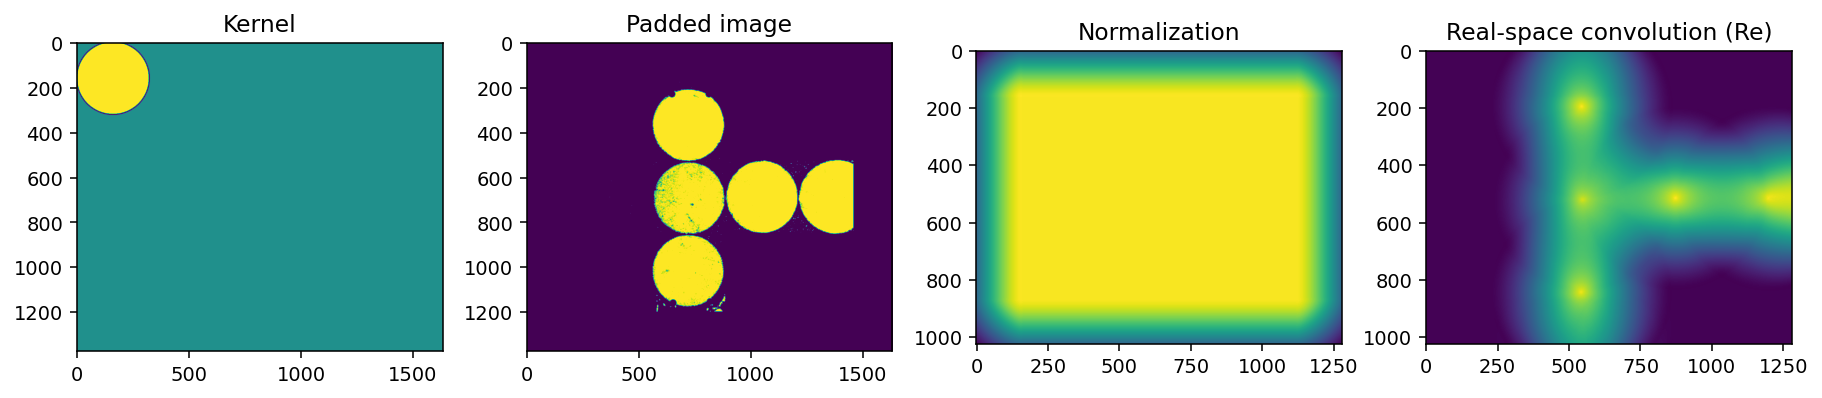

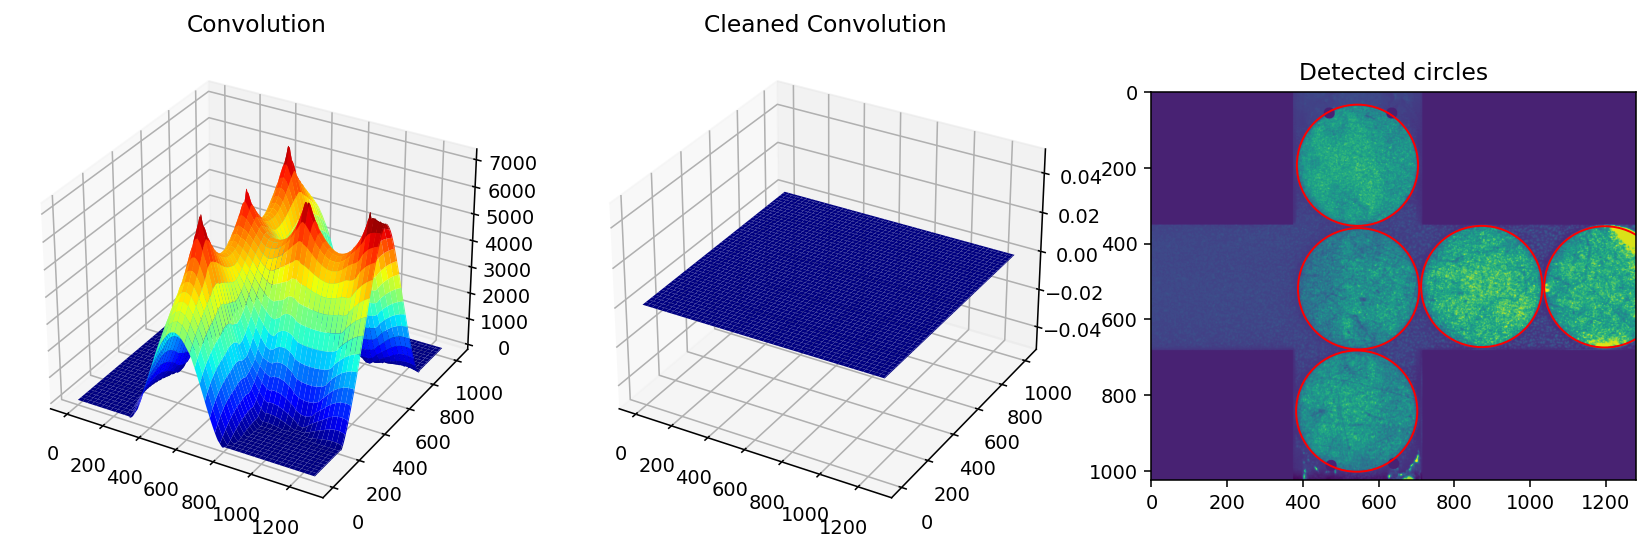

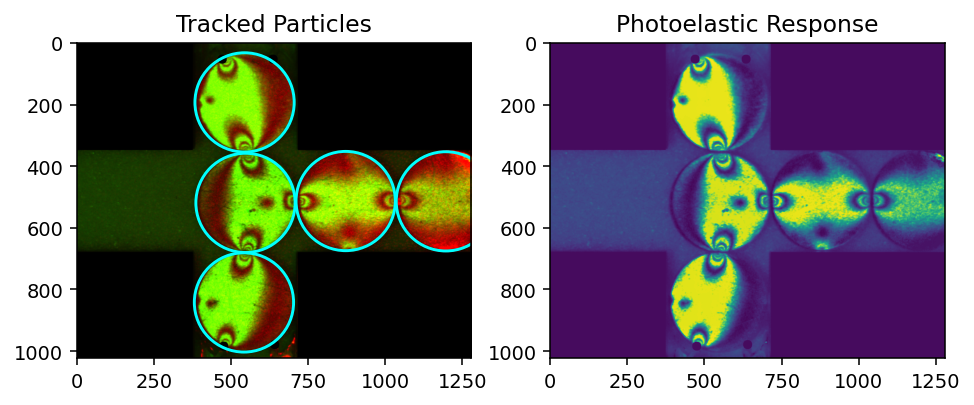

In [3]:
correction = lightCorrectionDiff(checkImageType(correctionImage),
                                checkImageType(verticalMaskImage)[:,:,0],
                                checkImageType(horizontalMaskImage)[:,:,0],
                                debug=False)

maskArr = checkImageType(maskImage)

# Make some fake data with several potential wall contacts

#image = checkImageType('test_data/Test_2022-01-28.bmp')
image = checkImageType(rootFolder + dataFolder + 'frame0201.bmp')

# g2 to force conversion is calibrated on the scale [0, 1], not [0, 255]
# We also blur the images a little, since they are visibly grainy
photoelasticChannel = cv2.blur((image[:,:,1] + correction[:,:,1]).astype(np.float64) / 255, (3,3))

centers, radii = convCircle((image[:,:,0] + correction[:,:,0]) * maskArr[:,:,0], guessRadius, **circleTrackingKwargs, debug=True)

centers = centers.astype(np.int64)
radii = radii.astype(np.int64)
# Make them all odd
radii += (radii % 2) == 0

fig, ax = plt.subplots(1, 2, figsize=(8, 4))

ax[0].imshow(maskArr * image)
for i in range(len(centers)):
    c = plt.Circle(centers[i][::-1], radii[i], color='cyan', fill=False, linewidth=1.5)
    ax[0].add_artist(c)
ax[0].set_title('Tracked Particles')

ax[1].imshow(photoelasticChannel * maskArr[:,:,0])
ax[1].set_title('Photoelastic Response')
plt.show()

In [3]:
forceArr, alphaArr, betaArr, centerArr, radiusArr = forceSolve(rootFolder + dataFolder,
                                                               inputSettingsFile='2022-03-29_Medium_Synthetic_HN_0/readme.txt',
                                                              outputExtension='_temp')

 99% (349 of 350) |#################### | Elapsed Time: 12:10:34 ETA:   0:00:02

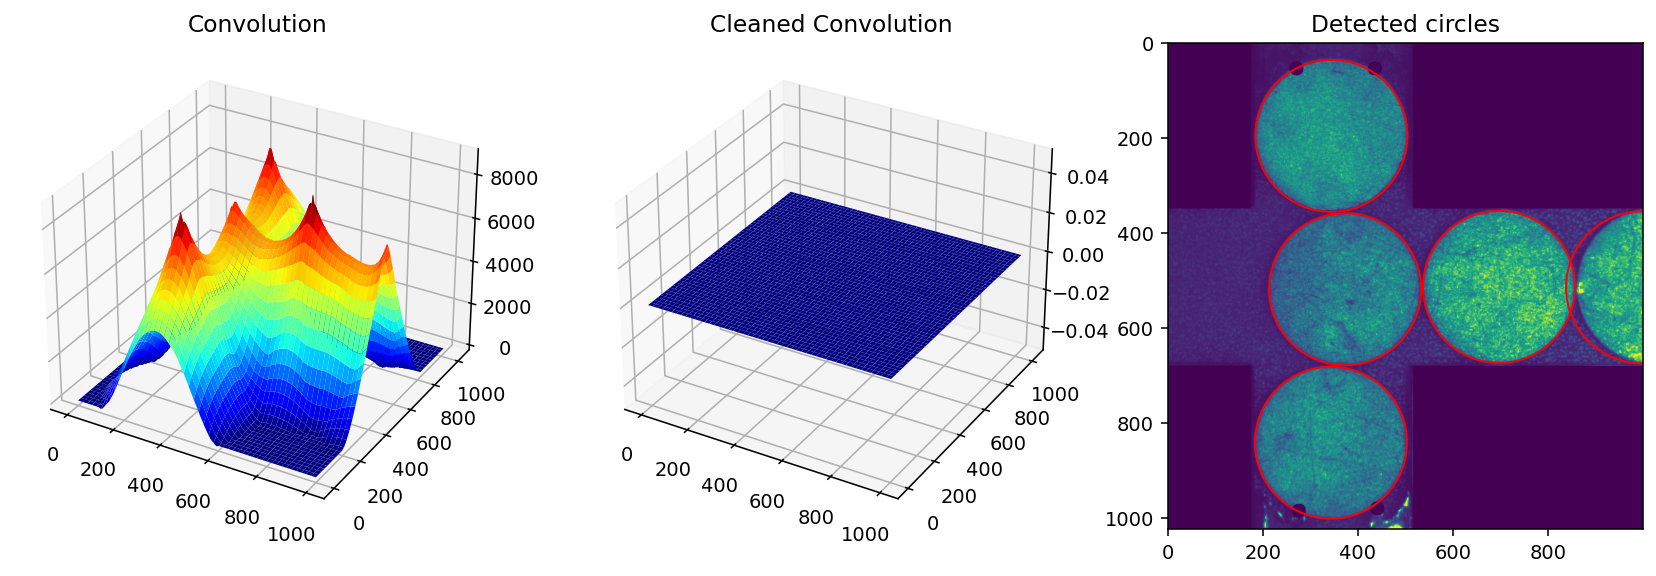

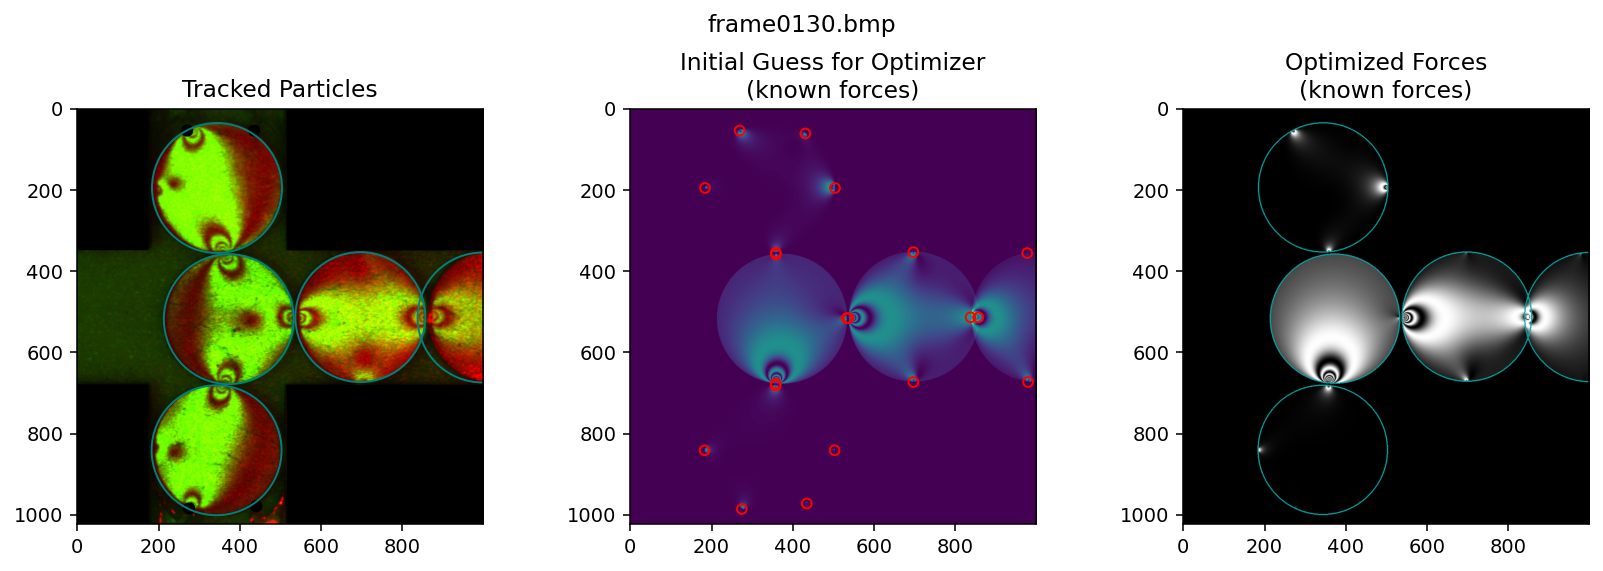

 90% (9 of 10) |######################   | Elapsed Time: 0:01:38 ETA:   0:00:11

Took 10.997s to solve frame:
     Tracking:         3.05s
     Initial guess:    0.453s
     Optimization:     5.69s
     Misc. processes:  1.8s


In [3]:
forceArr, alphaArr, betaArr, centerArr, radiusArr, angleArr = forceSolve(rootFolder + dataFolder, guessRadius, fSigma, pxPerMeter,
                                                        brightfield, maskImage=maskImage, cropXMin=cropXBounds[0], cropXMax=cropXBounds[1],
                                                        performOptimization=True,
                                                        lightCorrectionImage=correctionImage,
                                                        lightCorrectionVerticalMask=verticalMaskImage,
                                                        lightCorrectionHorizontalMask=horizontalMaskImage,
                                                        g2CalibrationImage=g2CalibrationImage, g2CalibrationCutoffFactor=2.,
                                                        imageStartIndex=120, imageEndIndex=130, carryOverAlpha=True,
                                                        optimizationKwargs=optimizationKwargs, circleTrackingKwargs=circleTrackingKwargs,
                                                        debug=True, saveMovie=True, pickleArrays=True,
                                                        outputExtension='_temp')

In [3]:
dataSet = 'LocalizedAlpha/2022-02-28_Wide_Synthetic_2/'

with open(dataSet + 'forces.pickle', 'rb') as f:
    forceArr = pickle.load(f)
with open(dataSet + 'betas.pickle', 'rb') as f:
    betaArr = pickle.load(f)
with open(dataSet + 'alphas.pickle', 'rb') as f:
    alphaArr = pickle.load(f)
with open(dataSet + 'centers.pickle', 'rb') as f:
    centerArr = pickle.load(f)
with open(dataSet + 'radii.pickle', 'rb') as f:
    radiusArr = pickle.load(f)

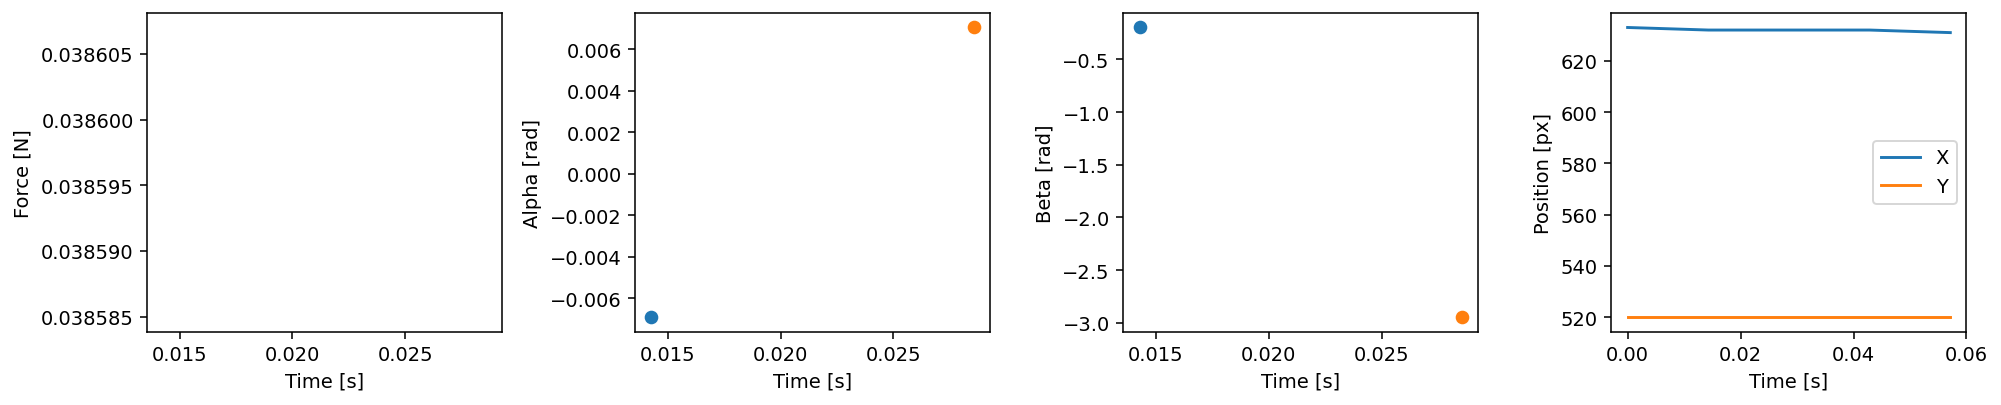

In [4]:
particleIndex = 1
fps = 70

fig, ax = visForces(forceArr[particleIndex], alphaArr[particleIndex], betaArr[particleIndex], centerArr[particleIndex], fps=fps)

plt.show()

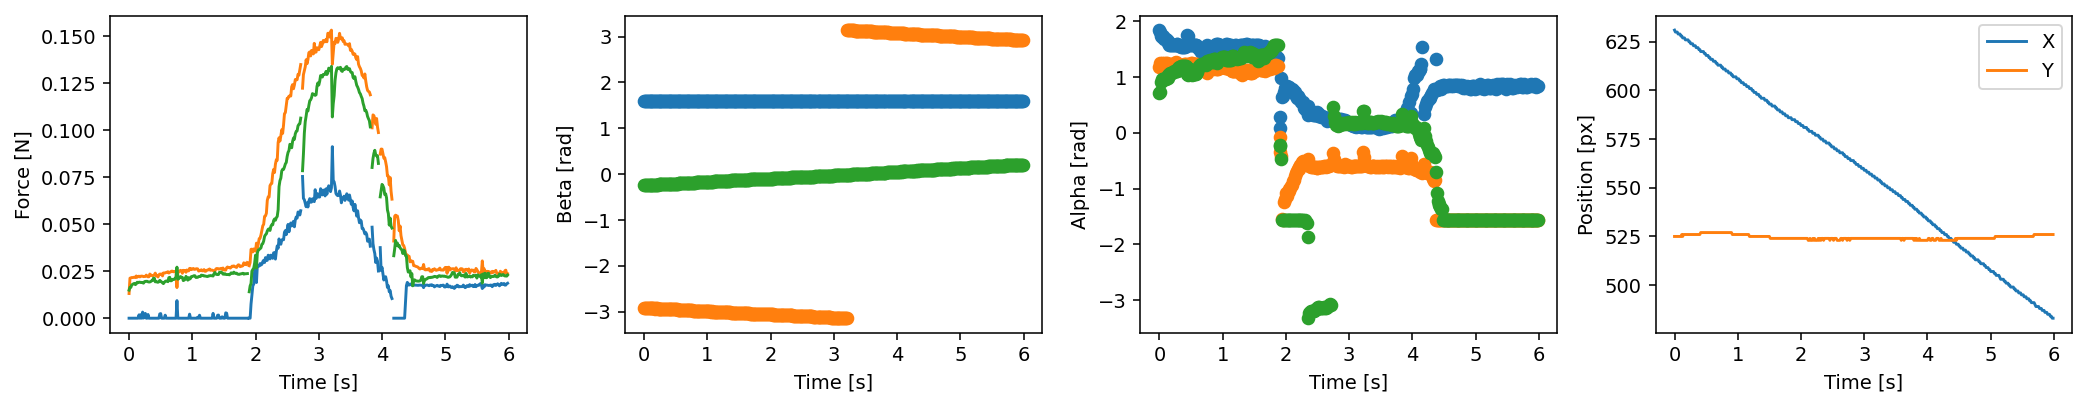

In [9]:
particleIndex = 1
fps = 70
tArr = np.arange(len(forceArr[3][0]))

fig, ax = plt.subplots(1, 4, figsize=(15,3))

ax[3].plot(tArr/fps, centerArr[particleIndex][:,1], label='X')
ax[3].plot(tArr/fps, centerArr[particleIndex][:,0], label='Y')

for i in range(len(betaArr[particleIndex])):
    ax[0].plot(tArr/fps, forceArr[particleIndex][i])
    ax[1].plot(tArr/fps, betaArr[particleIndex][i], 'o')
    ax[2].plot(tArr/fps, alphaArr[particleIndex][i], 'o')
    
ax[0].set_ylabel('Force [N]')
ax[1].set_ylabel('Beta [rad]')
ax[2].set_ylabel('Alpha [rad]')
ax[3].set_ylabel('Position [px]')
ax[3].legend()

for i in range(4):
    ax[i].set_xlabel('Time [s]')
    
fig.tight_layout()
plt.show()

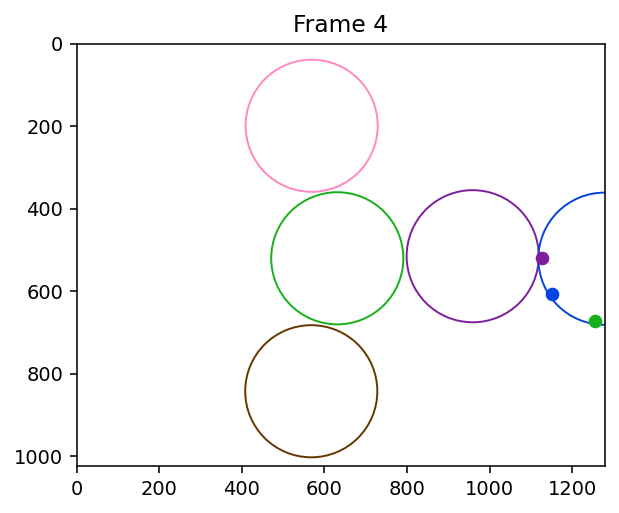

In [9]:
forceColors = [genColors(len(b), int(time.perf_counter()*1e6) % 1024) for b in betaArr]
tSteps = 5
images = [None for i in range(tSteps)]

for i in range(tSteps):
    clear_output(wait=True)
    fig, ax = plt.subplots()
    
    visCircles([centerArr[p][i] for p in range(len(centerArr))], [radiusArr[p][i] for p in range(len(radiusArr))], ax=ax)
    
    for particleIndex in range(len(betaArr)):
        visContacts(centerArr[particleIndex][i], radiusArr[particleIndex][i],
                    betaArr[particleIndex][:,i], ax=ax, forceColors=forceColors[particleIndex])#, alphaArr=alphaArr[particleIndex][:,i])
        
    ax.set_xlim([0, 1280])
    ax.set_ylim([0, 1024])
    ax.set_aspect('equal')
    ax.set_title(f'Frame {i}')
    ax.invert_yaxis()
    canvas = plt.get_current_fig_manager().canvas
    canvas.draw()
    images[i] = Image.frombytes('RGB', canvas.get_width_height(), 
                 canvas.tostring_rgb())
    plt.show()

#images[0].save(dataSet + 'contact_tracking.gif', save_all=True, append_images=images[1:], duration=25, optimize=True, loop=True)

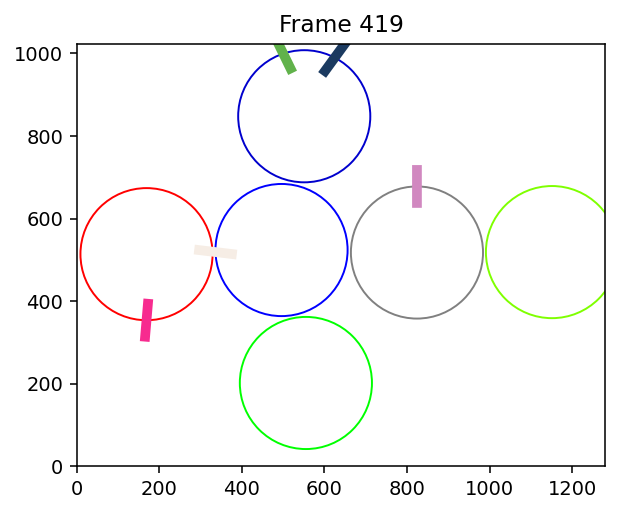

In [6]:
forceColors = [genRandomColors(len(b), int(time.perf_counter()*1e6) % 1024) for b in betaArr]
tSteps = len(betaArr[0][0])
images = [None for i in range(tSteps)]
for i in range(len(alphaArr)):
    alphaArr[i][np.where(np.isnan(alphaArr[i]))] = 0

for i in range(tSteps):
    clear_output(wait=True)
    fig, ax = plt.subplots()
    
    visCircles([centerArr[p][i] for p in range(len(centerArr))], [radiusArr[p][i] for p in range(len(radiusArr))], ax=ax)

    for particleIndex in range(len(betaArr)):
        visContacts(centerArr[particleIndex][i], radiusArr[particleIndex][i],
                    betaArr[particleIndex][:,i], ax=ax, forceColors=forceColors[particleIndex], alphaArr=alphaArr[particleIndex][:,i])
        
    ax.set_xlim([0, 1280])
    ax.set_ylim([0, 1024])
    ax.set_aspect('equal')
    ax.set_title(f'Frame {i}')
    
    canvas = plt.get_current_fig_manager().canvas
    canvas.draw()
    images[i] = Image.frombytes('RGB', canvas.get_width_height(), 
                 canvas.tostring_rgb())
    plt.show()

images[0].save(dataSet + 'contact_angle_tracking.gif', save_all=True, append_images=images[1:], duration=25, optimize=True, loop=True)